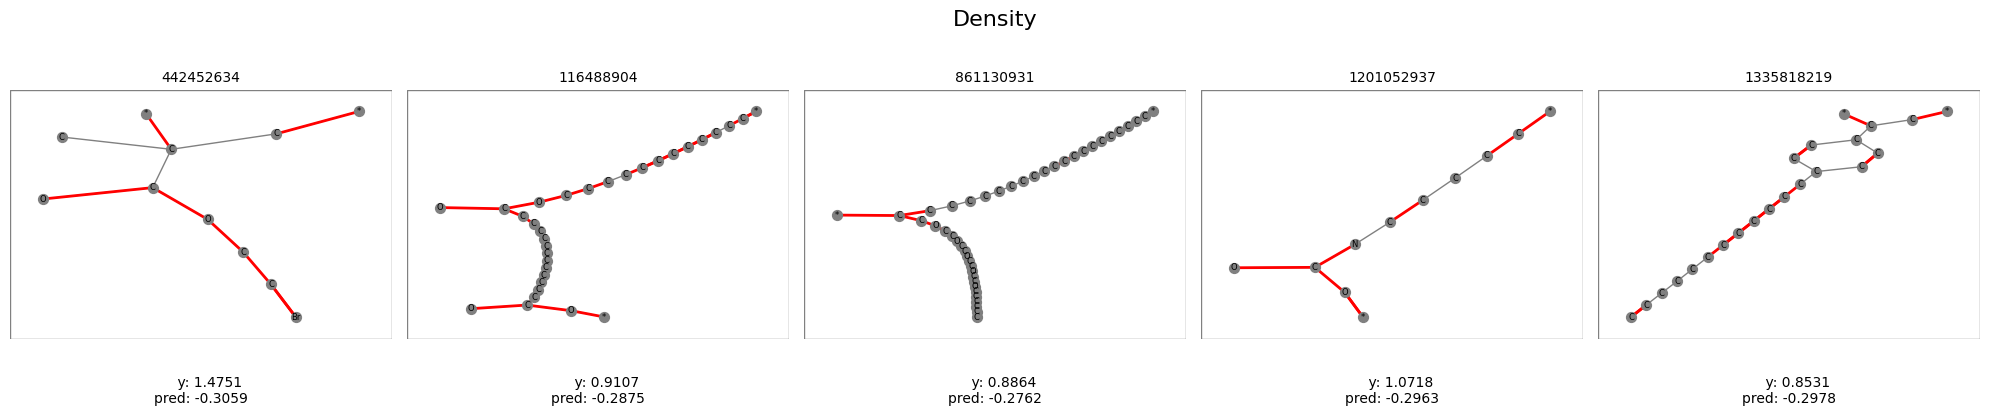

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GraphConv, BatchNorm, global_mean_pool
import random

elements = {
    '*': 0, 'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
    'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28,'Cu': 29, 'Zn': 30,
    'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
    'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46,'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
    'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
    'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
    'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92, 'Np': 93, 'Pu': 94, 'Am': 95, 'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 'Fm': 100,
    'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109,
    'Ds': 110, 'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 'Og': 118
}
idx_to_element = {v: k for k, v in elements.items()}


class Predictor(nn.Module):
    def __init__(self, in_channels, hid_channels=64, num_outputs=1, conv_unit=3):
        super(Predictor, self).__init__()
        self.node_emb = nn.Linear(in_channels, hid_channels)
        self.hid_channels = hid_channels
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.relus = nn.ModuleList()

        for _ in range(conv_unit):
            conv = GraphConv(in_channels=hid_channels, out_channels=hid_channels)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hid_channels))
            self.relus.append(nn.ReLU())

        self.causal_mlp = nn.Sequential(
            nn.Linear(hid_channels, 2 * hid_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2 * hid_channels, hid_channels),
            nn.ReLU(),
            nn.Linear(hid_channels, num_outputs),
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_x = self.get_node_reps(x, edge_index, edge_attr)
        graph_x = global_mean_pool(node_x, batch)
        logits = self.get_causal_pred(graph_x)
        return logits 

    def get_node_reps(self, x, edge_index, edge_attr):
        edge_weight = edge_attr.view(-1) if edge_attr is not None else None

        if x.size(1) != self.hid_channels:
            x = self.node_emb(x)

        for conv, batch_norm, relu in zip(self.convs, self.batch_norms, self.relus):
            if edge_weight is not None:
                x = conv(x, edge_index, edge_weight=edge_weight)
            else:
                x = conv(x, edge_index)
            x = relu(batch_norm(x))
        return x

    def get_causal_pred(self, causal_graph_x):
        return self.causal_mlp(causal_graph_x)


class Rationale_Generator(nn.Module):
    def __init__(self, in_channels, causal_ratio, channels=64):
        super(Rationale_Generator, self).__init__()

        self.conv1 = GraphConv(in_channels=in_channels, out_channels=channels)
        self.conv2 = GraphConv(in_channels=channels, out_channels=channels)
        self.mlp = nn.Sequential(
            nn.Linear(channels * 2, channels * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(channels * 4, 1),
        )
        self.ratio = causal_ratio

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)

        row, col = data.edge_index
        edge_rep = torch.cat([x[row], x[col]], dim=-1)
        edge_score = self.mlp(edge_rep).view(-1)

        return x, edge_score


def load_graphs(pt_path):
    return torch.load(pt_path, weights_only=False)


def relabel(x, edge_index, batch=None, pos=None):
    if edge_index.numel() == 0:
        empty_batch = batch[:0] if batch is not None else torch.zeros(0, dtype=torch.long, device=x.device)
        return x[:0], edge_index, empty_batch, pos

    num_nodes = x.size(0)
    sub_nodes = torch.unique(edge_index)
    x = x[sub_nodes]

    if batch is None:
        batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
    else:
        batch = batch[sub_nodes]

    row, col = edge_index
    node_idx = row.new_full((num_nodes,), -1)
    node_idx[sub_nodes] = torch.arange(sub_nodes.size(0), device=row.device)
    edge_index = node_idx[edge_index]

    if pos is not None:
        pos = pos[sub_nodes]

    return x, edge_index, batch, pos


def plot_graphs_one_row(graph_list, rationale_generator, predictor, device, dataset_name, n_graphs=10):
    plt.figure(figsize=(20, 4))
    plt.suptitle(dataset_name, fontsize=16, y=1.05)

    selected_graphs = random.sample(graph_list, min(n_graphs, len(graph_list)))

    for i, graph in enumerate(selected_graphs):
        graph = graph.to(device)
        x, edge_score = rationale_generator(graph)
        n_reserve = max(1, int(rationale_generator.ratio * edge_score.size(0)))
        _, idx_reserve = torch.topk(edge_score, n_reserve)
        causal_edge_index = graph.edge_index[:, idx_reserve]

        causal_x, causal_edge_index_relabeled, causal_batch, _ = relabel(
            graph.x, causal_edge_index, batch=None
        )
        edge_attr = torch.ones(causal_edge_index_relabeled.size(1), 1).to(device)

        with torch.no_grad():
            node_reps = predictor.get_node_reps(
                x=causal_x,
                edge_index=causal_edge_index_relabeled,
                edge_attr=edge_attr
            )
            graph_rep = global_mean_pool(node_reps, causal_batch)
            out = predictor.get_causal_pred(graph_rep)
            pred_val = out.item() if out.numel() == 1 else out.mean().item()

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        node_labels = {i: idx_to_element.get(torch.argmax(graph.x[i]).item(), '?') for i in range(graph.num_nodes)}

        ax = plt.subplot(1, n_graphs, i + 1)

        if hasattr(graph, 'name'):
            ax.set_title(str(graph.name), fontsize=10)
        else:
            ax.set_title(f'Graph {i + 1}', fontsize=10)

        true_y = graph.y.item()
        ax.text(
            0.5, -0.15,
            f'    y: {true_y:.4f}\npred: {pred_val:.4f}',
            fontsize=10,
            ha='center',
            va='top',
            transform=ax.transAxes
        )

        nx.draw(
            G,
            pos,
            node_color="gray",
            edge_color="gray",
            node_size=50,
            labels=node_labels,
            with_labels=True,
            font_size=6,
            ax=ax,
        )
        causal_edges = [(graph.edge_index[0][j].item(), graph.edge_index[1][j].item()) for j in idx_reserve]
        nx.draw_networkx_edges(
            G, pos, edgelist=causal_edges, edge_color="red", width=2, ax=ax
        )

        ax.axis('off')

        rect = patches.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            linewidth=1,
            edgecolor='gray',
            facecolor='none',
            zorder=10
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    attribute_folder = "Density"  
    rationale_generator_path = f"../DIR_results/{attribute_folder}/rationale_generator.pt"
    predictor_path = f"../DIR_results/{attribute_folder}/predictor.pt"

    train_path = f"../data/{attribute_folder}/train.pt"
    val_path = f"../data/{attribute_folder}/val.pt"
    test_path = f"../data/{attribute_folder}/test.pt"

    train_graphs = load_graphs(train_path)
    val_graphs = load_graphs(val_path)
    test_graphs = load_graphs(test_path)

    in_channels = train_graphs[0].x.size(1)

    rationale_generator = Rationale_Generator(
        in_channels, causal_ratio=0.42, channels=64
    ).to(device)
    predictor = Predictor(in_channels, hid_channels=64, num_outputs=1).to(device)

    rationale_generator.load_state_dict(
        torch.load(rationale_generator_path, map_location=device)
    )
    rationale_generator.eval()
    predictor.load_state_dict(torch.load(predictor_path, map_location=device))
    predictor.eval()

    plot_graphs_one_row(
        train_graphs, rationale_generator, predictor, device, attribute_folder, n_graphs=5
    )


if __name__ == "__main__":
    main()
